In [1]:
# 导入环境的包
import time
import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

from tcn import TCN
from tensorflow.keras.layers import Dense,Dropout,GRU
from tensorflow.keras import Input, Model,Sequential

In [2]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [3]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
daily_cases_ = pd.read_csv('../new_daily_cases/new_daily_cases_China.csv').iloc[:,1:]
df_resample=daily_cases_.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,7895.0
5/11/22,7357.0
5/12/22,7118.0
5/13/22,6768.0


In [5]:
## * Note: 归一化数据范围为0-1.

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [6]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
train = values[400:-7, :]
test = values[-7:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(435, 1, 1) (435,) (7, 1, 1) (7,)


# 构建TCN-GRU模型

### 1) TCN 卷积核个数32
### 2) GRU隐藏层100
### 3) dropout 层20%
### 4) 1个神经元在输出层中。
### 5) 输入形状为1个时间步长，有1个特征

### 6)使用了平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam。
### 7)  epochs=100, batch size = 8.

In [7]:
time_start = time.time()  # 记录开始时间
#网络结构
model = Sequential()
model.add(TCN(nb_filters=32,kernel_size=3,padding='causal',return_sequences=True,dilations=(1, 2, 4, 8,16), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(GRU(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("train time:",time_sum)


# 显示训练的loss值情况
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss in TCN-GRU')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

time_start = time.time()  # 记录开始时间
# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("predict time:",time_sum)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

Epoch 1/100
55/55 - 4s - loss: 0.0112 - val_loss: 4.6260e-04
Epoch 2/100
55/55 - 0s - loss: 0.0229 - val_loss: 0.0113
Epoch 3/100
55/55 - 0s - loss: 0.0314 - val_loss: 0.0124
Epoch 4/100
55/55 - 0s - loss: 0.0067 - val_loss: 4.8502e-05
Epoch 5/100
55/55 - 0s - loss: 0.0105 - val_loss: 6.9964e-04
Epoch 6/100
55/55 - 0s - loss: 0.0121 - val_loss: 0.0090
Epoch 7/100
55/55 - 0s - loss: 0.0059 - val_loss: 2.2943e-04
Epoch 8/100
55/55 - 0s - loss: 0.0041 - val_loss: 8.6486e-04
Epoch 9/100
55/55 - 0s - loss: 0.0038 - val_loss: 4.2657e-04
Epoch 10/100
55/55 - 0s - loss: 0.0044 - val_loss: 0.0018
Epoch 11/100
55/55 - 0s - loss: 0.0044 - val_loss: 9.7118e-04
Epoch 12/100
55/55 - 0s - loss: 0.0036 - val_loss: 0.0029
Epoch 13/100
55/55 - 0s - loss: 0.0040 - val_loss: 0.0024
Epoch 14/100
55/55 - 0s - loss: 0.0041 - val_loss: 0.0035
Epoch 15/100
55/55 - 0s - loss: 0.0041 - val_loss: 0.0024
Epoch 16/100
55/55 - 0s - loss: 0.0041 - val_loss: 0.0041
Epoch 17/100
55/55 - 0s - loss: 0.0050 - val_loss: 0.

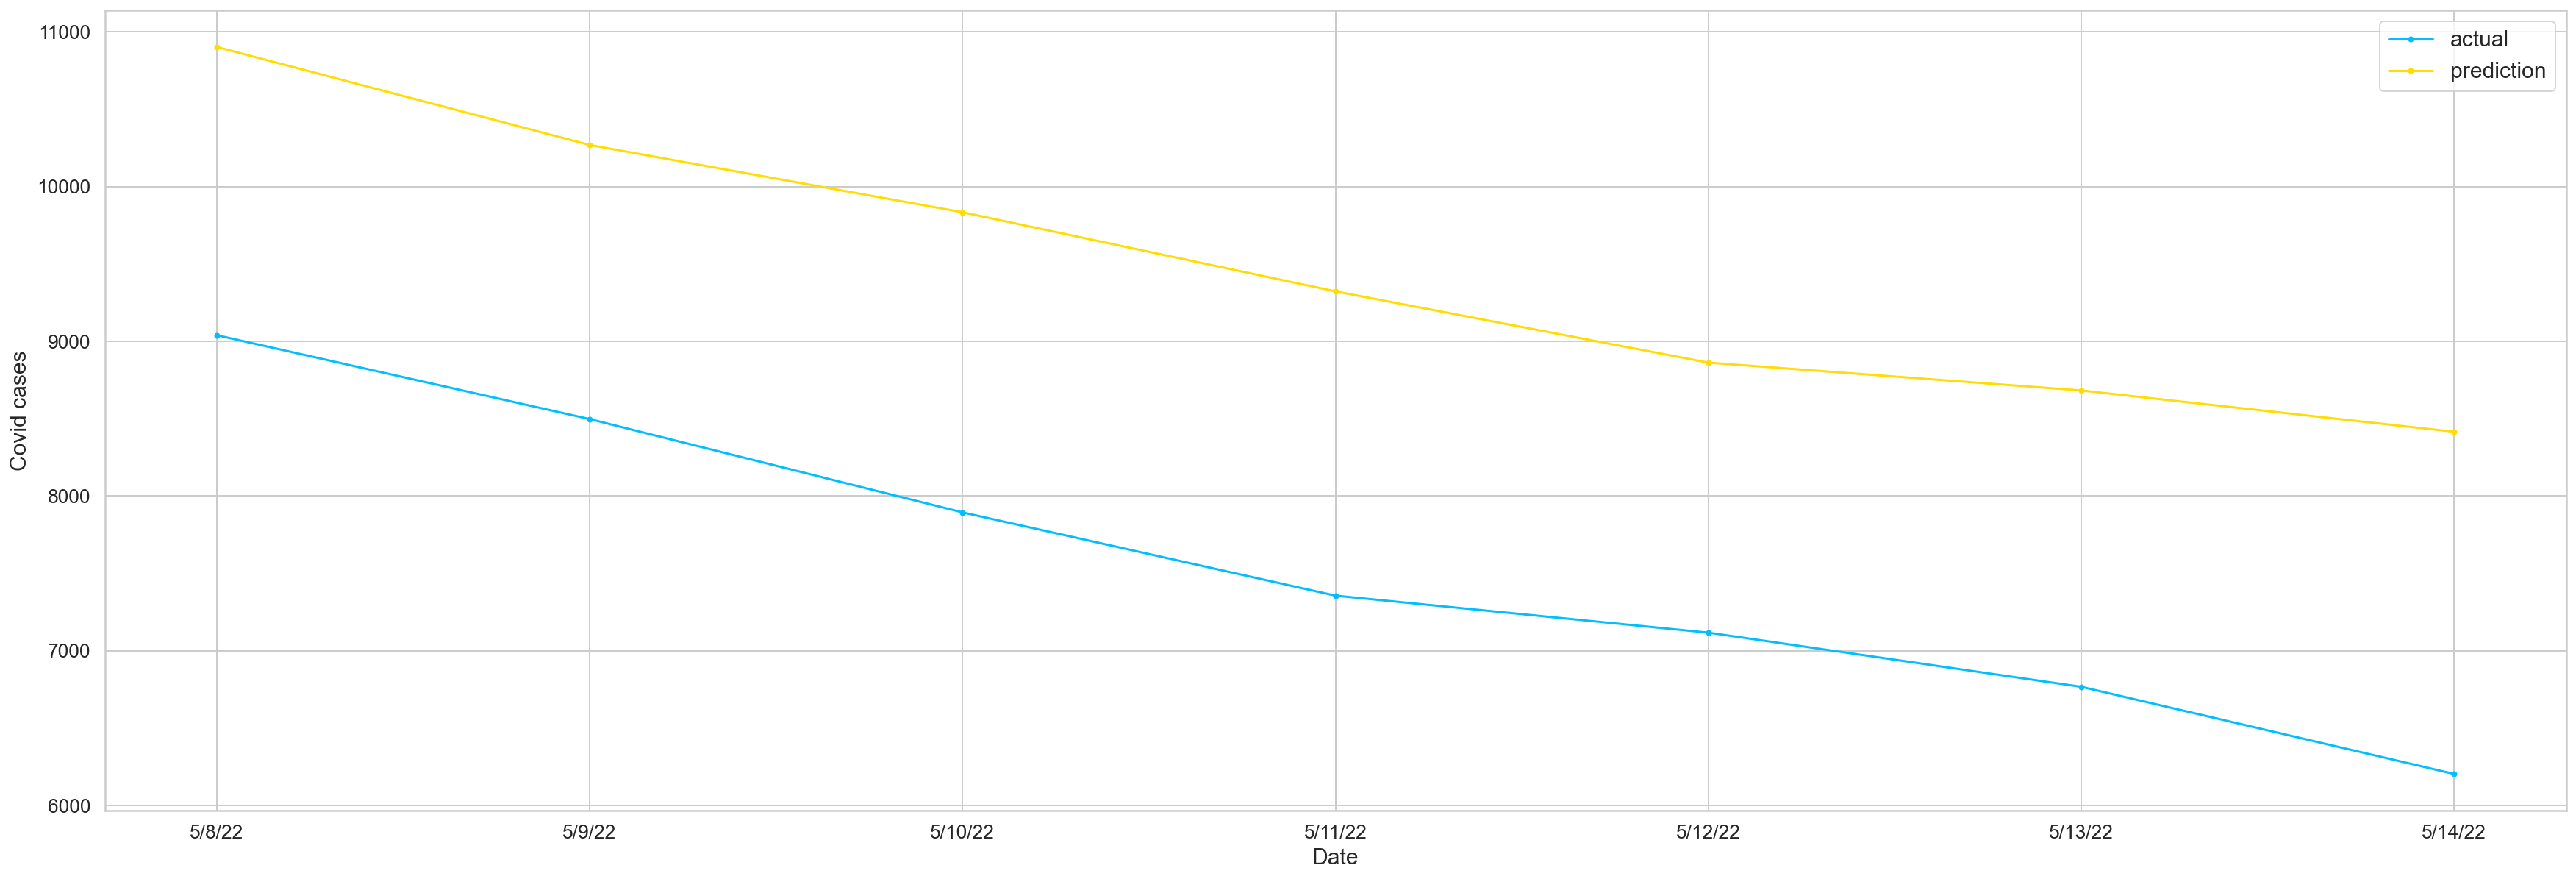

In [8]:
# 显示预测结果
plt.plot(df_resample.index[-7:], inv_y[-7:], marker='.', label="actual")
plt.plot(df_resample.index[-7:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [9]:
true_cases=inv_y
predicted_cases=inv_yhat
predicted_cases.astype(int)

array([10902, 10268,  9834,  9323,  8862,  8682,  8415])

In [10]:

# MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)

RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5

NRMSE=RMSE/(np.max(true_cases)-np.min(true_cases))

# MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

MAPE=100 * np.mean(np.abs(true_cases-predicted_cases)) / np.mean(true_cases) 

SMAPE=200 * np.mean(np.abs(true_cases-predicted_cases) / (np.abs(true_cases) + np.abs(predicted_cases))) 


RMSE = round(RMSE,4)

NRMSE = round(NRMSE,4)

MAPE = round(MAPE,4)

SMAPE = round(SMAPE,4)

summary=[RMSE,NRMSE,MAPE,SMAPE]

summary

[1920.7757, 0.6775, 25.3552, 22.8364]

In [11]:
history.history['loss']

[0.011240381747484207,
 0.022939560934901237,
 0.03138085454702377,
 0.006665381602942944,
 0.010533999651670456,
 0.012060637585818768,
 0.005899040028452873,
 0.004145424347370863,
 0.003815300529822707,
 0.004354648757725954,
 0.004439108073711395,
 0.0035563535057008266,
 0.003999875392764807,
 0.0040816133841872215,
 0.004084035288542509,
 0.004136059898883104,
 0.0050337184220552444,
 0.003570581553503871,
 0.004265403375029564,
 0.003852464724332094,
 0.00488982442766428,
 0.0035541721154004335,
 0.003639393486082554,
 0.0034055013675242662,
 0.003742585889995098,
 0.003649970516562462,
 0.004431631416082382,
 0.003003784455358982,
 0.0035725694615393877,
 0.003323654644191265,
 0.004216713365167379,
 0.0038801960181444883,
 0.0032974951900541782,
 0.0028167045675218105,
 0.003685274627059698,
 0.0032802820205688477,
 0.002905000001192093,
 0.003330819308757782,
 0.00297731370665133,
 0.002428601961582899,
 0.0030452576465904713,
 0.003166354028508067,
 0.002921129111200571,
 0.

In [12]:
history.history['val_loss']

[0.00046260427916422486,
 0.011314916424453259,
 0.012366578914225101,
 4.8502184654353186e-05,
 0.0006996419397182763,
 0.008984529413282871,
 0.00022943095245864242,
 0.0008648597286082804,
 0.00042657009907998145,
 0.0018467645859345794,
 0.0009711774764582515,
 0.0029181696008890867,
 0.002357876393944025,
 0.0035251458175480366,
 0.002433983376249671,
 0.004119175486266613,
 0.0012844821903854609,
 0.004844681825488806,
 0.0019878221210092306,
 0.005175833590328693,
 0.0022562083322554827,
 0.008626977913081646,
 0.002846373477950692,
 0.005235073156654835,
 0.0037693767808377743,
 0.00974005926400423,
 0.002154221525415778,
 0.008848169818520546,
 0.0034963469952344894,
 0.006672381889075041,
 0.0021326697897166014,
 0.007018267642706633,
 0.001819411525502801,
 0.0043106661178171635,
 0.002550173318013549,
 0.00859835185110569,
 0.0035026625264436007,
 0.006569552700966597,
 0.0035756644792854786,
 0.0065262652933597565,
 0.0024377971421927214,
 0.004307039547711611,
 0.00211097